# Group 3: Diagnosing Respiratory Disease from Chest X-Rays using Computer Vision

### Set Options for Classification, Modeling, and Training 

- Classification options:
    - 4-way Multiclass Classification
        - Normal
        - COVID
        - Viral Pneumonia
        - Lung Opacity
    - Binary Classification
        - Normal
        - COVID

- Model options:
    - ResNet18
    - VGG16
  
- Training options:
    - Finetuning
    - Train from scratch

In [44]:
# List of options
classification_options = ['multiclass', 'binary']
model_options = ['resnet', 'vgg']
training_options = ['finetune', 'scratch']

# Example of choices to be used for this notebook
classification_task = 'multiclass'
model_type = 'resnet'
training_task = 'finetune'

### Importing Libraries

In [45]:
import torchvision
import numpy as np
import shutil
import random
import torch
import os

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

### Dataset Classes

- Dataset for multiclass or binary classification

In [46]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, image_dirs, transform, classification_task):
        
        # Get all images for a given class
        def get_images(class_name):
            image_type = 'png'
            class_dir = image_dirs[class_name]
            images = [x for x in os.listdir(class_dir) if x.lower().endswith(image_type)] 
            num_images = len(images)
            print(f'{class_name}: {num_images} images')
            return images
        
        # Set classes and initialize images
        self.classification_task = classification_task
        if classification_task == 'multiclass':
            self.classes = ['normal', 'viral', 'covid', 'opacity']
        else:
            self.classes = ['normal', 'covid']
        self.images = {}
        
        # Get images for each class
        for c in self.classes:
            self.images[c] = get_images(c)
            
        # Get directories and transforms
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        # Get number of images
        length = sum([len(self.images[x]) for x in self.classes])
        return length
    
    def __getitem__(self, index):
        # Get random formatted image and class
        rand_class = random.choice(self.classes)
        rand_idx = index % len(self.images[rand_class])
        rand_name = self.images[rand_class][rand_idx]
        rand_path = os.path.join(self.image_dirs[rand_class], rand_name)
        rand_image_raw = Image.open(rand_path).convert('RGB')
        rand_image_trans = self.transform(rand_image_raw)
        rand_indexed_class = self.classes.index(rand_class)
        return rand_image_trans, rand_indexed_class

### Transformations

- Normalizing images using mean and standard deviation RGD values from ImageNet

In [47]:
dim = 224
r_mean = 0.485
g_mean = 0.456
b_mean = 0.406
r_std = 0.229
g_std = 0.224
b_std = 0.225

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (dim,dim)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [r_mean, g_mean, b_mean],
                                     std = [r_std, g_std, b_std])
])

### Set Directories for Train / Val / Test

In [48]:
# Set train/val/test directories
train_dirs = {
    'normal': 'train_val_test/train/Normal_images',
    'viral': 'train_val_test/train/Viral Pneumonia_images',
    'covid': 'train_val_test/train/COVID_images',
    'opacity': 'train_val_test/train/Lung_Opacity_images',
}

val_dirs = {
    'normal': 'train_val_test/val/Normal_images',
    'viral': 'train_val_test/val/Viral Pneumonia_images',
    'covid': 'train_val_test/val/COVID_images',
    'opacity': 'train_val_test/val/Lung_Opacity_images',
}

test_dirs = {
    'normal': 'train_val_test/test/Normal_images',
    'viral': 'train_val_test/test/Viral Pneumonia_images',
    'covid': 'train_val_test/test/COVID_images',
    'opacity': 'train_val_test/test/Lung_Opacity_images',
}

### Create Datasets for Train / Val / Test

In [49]:
print('Training Data:')
train_dataset = Dataset(train_dirs,
                        transform,
                        classification_task)

print('\nValidation Data:')
val_dataset = Dataset(val_dirs,
                      transform,
                      classification_task)

print('\nTesting Data:')
test_dataset = Dataset(test_dirs,
                       transform,
                       classification_task)

Training Data:
normal: 6115 images
viral: 807 images
covid: 2169 images
opacity: 3607 images

Validation Data:
normal: 3057 images
viral: 403 images
covid: 1084 images
opacity: 1803 images

Testing Data:
normal: 1020 images
viral: 135 images
covid: 363 images
opacity: 602 images


### Set Dataloaders for Train / Val / Test

In [50]:
# Set batch size 
n = 4

# Create train / val / test loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=n,
                                       shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=n,
                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                      batch_size=n,
                                      shuffle=True)

# Calculate number of batches
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
num_test_batches = len(test_loader)

# Print number of batches
print(f'Batches in training data loader: {num_train_batches}')
print(f'Batches in validation data loader: {num_val_batches}')
print(f'Batches in test data loader: {num_test_batches}')

Batches in training data loader: 3175
Batches in validation data loader: 1587
Batches in test data loader: 530


### Set Model

In [51]:
def set_model(training_task, model_type):
    if training_task == 'finetune':
        if model_type == 'resnet':
            model = torchvision.models.resnet18(pretrained=True)
        elif model_type == 'vgg':
            model = torchvision.models.vgg16(pretrained=True)
    elif training_task == 'finetune':
        if model_type == 'resnet':
            model = torchvision.models.resnet18(weights=None)
        elif model_type == 'vgg':
            model = torchvision.models.vgg16(weights=None)
    return model

In [52]:
training_task = 'finetune'
model_type = 'resnet'
model = set_model(training_task, model_type)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
# Set number of out features based on classification task
def linear_layers(model, classification_task):
    if classification_task == 'multiclass':
        model.fc = torch.nn.Linear(in_features=512, out_features=4)
    elif classification_task == 'binary':
        model.fc = torch.nn.Linear(in_features=512, out_features=2)

In [54]:
linear_layers(model, classification_task)

In [55]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

# Training the Model

In [59]:
def train(num_epochs, model, classification_task):
    
    # Set sig figs, initialize accuracy and loss lists
    num_decimals = 5
    acc_list = []
    loss_list = []
    step_list = []
    
    # Loop through each epoch
    for i in range(0, num_epochs):
        print(f'Epoch: {i}')

        # Initialize losses
        train_loss = 0.
        val_loss = 0.

        # Set model to training
        model.train()
        
        # Loop through training steps
        for step, (images, labels) in enumerate(train_loader):
            
            # Set gradients to zero
            optimizer.zero_grad()
            
            # Get outputs of model, calculate loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Take optimal step, add to training loss
            optimizer.step()
            train_loss += loss.item()
            
            # Evaluate every 20th step
            if step % 20 == 0:
                print(f'Step: {step}')
                
                # Initialize accuracy, set resnet to evaluation
                accuracy = 0
                model.eval()

                # Loop through validation steps
                for val_step, (images, labels) in enumerate(val_loader):
                    
                    # Get outputs of model, calculate loss, add to validation loss
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    # Get predictions of model, calculate and add to accuracy
                    _, preds = torch.max(outputs, 1)
                    val_acc = sum((preds == labels).numpy())
                    accuracy += val_acc
                    
                # Calculate and print validation loss and accuracy
                val_loss = val_loss / (val_step + 1)
                accuracy = accuracy / len(val_dataset)
                
                # Add metrics to lists
                loss_list.append(val_loss)
                acc_list.append(accuracy)
                step_list.append(step)
                
                # Print results
                print(f'Validation loss: {round(val_loss, num_decimals)}')
                print(f'Accuracy: {round(accuracy, num_decimals)}')
                
                # Set resnet back to training
                model.train()

                # Setting accuracy threshold
                if classification_task == 'multiclass':
                    acc_threshold = 0.95
                elif classification_task == 'binary':
                    acc_threshold = 0.90
                    
                # Stop training if accuracy threshold reached
                if accuracy >= acc_threshold:
                    print(f'Accuracy threshold reached')
                    return acc_list, loss_list, step_list
                
                # Stop training if maximum numnber of steps reached
                if step > 1:
                #if step >= 500:
                    print(f'Maximum number of steps reached')
                    return acc_list, loss_list, step_list

        # Calculate and print training loss
        train_loss = train_loss / (step + 1)
        print(f'Training loss: {round(train_loss, num_decimals)}')

In [14]:
%%time

train(num_epochs=1, model=model, classification_task='multiclass')

Epoch: 0
Step: 0
Validation loss: 1.57809
Accuracy: 0.24358
Step: 20
Validation loss: 1.21234
Accuracy: 0.43674
Step: 40
Validation loss: 0.91523
Accuracy: 0.61698
Step: 60
Validation loss: 0.74546
Accuracy: 0.70427
Step: 80
Validation loss: 0.65135
Accuracy: 0.76146
Step: 100
Validation loss: 0.61411
Accuracy: 0.77485
Step: 120
Validation loss: 0.57911
Accuracy: 0.79345
Step: 140
Validation loss: 0.51065
Accuracy: 0.82779
Step: 160
Validation loss: 0.48902
Accuracy: 0.82133
Step: 180
Validation loss: 0.45773
Accuracy: 0.84418
Step: 200
Validation loss: 0.47808
Accuracy: 0.82181
Step: 220
Validation loss: 0.41799
Accuracy: 0.85363
Step: 240
Validation loss: 0.38982
Accuracy: 0.86245
Step: 260
Validation loss: 0.37092
Accuracy: 0.8686
Step: 280
Validation loss: 0.3952
Accuracy: 0.84733
Step: 300
Validation loss: 0.37142
Accuracy: 0.87254
Step: 320
Validation loss: 0.34215
Accuracy: 0.88467
Step: 340
Validation loss: 0.37112
Accuracy: 0.87207
Step: 360
Validation loss: 0.36848
Accuracy: 

### Save Model

In [62]:
### BOTH MODEL ALREADY SAVED ###
file_name = training_task + '_' + classification_task + '_' + model_type + '.pth'
print(file_name)
#torch.save(model.state_dict(), file_name)

finetune_multiclass_resnet.pth


### Plot Training Results

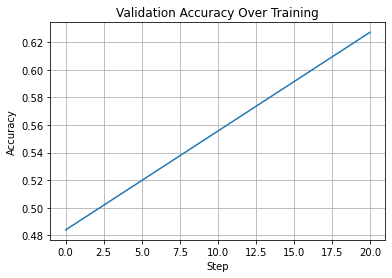

In [69]:
# Plot Validation Accuracy
plt.plot(step_list, acc_list)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Training')
plt.grid()

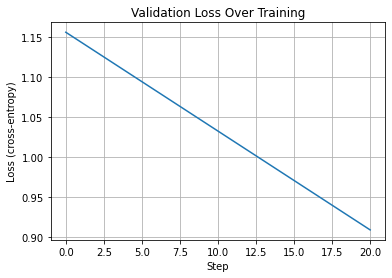

In [70]:
# Plot Validation Loss
plt.plot(step_list, loss_list)
plt.xlabel('Step')
plt.ylabel('Loss (cross-entropy)')
plt.title('Validation Loss Over Training')
plt.grid()

### Evaluate Model on Test Data

In [72]:
# Gather list of batched labels and predictions
label_list = []
pred_list = []

# Make predictions on test data, gather labels and predictions
print(f'Number of test batches: {num_test_batches}')
for test_step, (images, labels) in enumerate(test_loader):
    
    # Get outputs of model, calculate loss
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Get predictions of model, collect labels and predictions
    _, preds = torch.max(outputs, 1)
    label_list.append(labels)
    pred_list.append(preds)
    
    # Print number of steps
    if test_step % 25 == 0:
        print(f'Step: {test_step}')

Number of test batches: 530
Step: 0
Step: 25
Step: 50
Step: 75
Step: 100
Step: 125
Step: 150
Step: 175
Step: 200
Step: 225
Step: 250
Step: 275
Step: 300
Step: 325
Step: 350
Step: 375
Step: 400
Step: 425
Step: 450
Step: 475
Step: 500
Step: 525


In [73]:
# Convert batched labels/predictions to overall labels/predictions
label_vals = []
pred_vals = []
for i in range(len(label_list)):
    label_i = label_list[i]
    pred_i = pred_list[i]
    for j in label_i:
        label_vals.append(j.item())
    for k in pred_i:
        pred_vals.append(k.item())

In [79]:
# Make list of diagnoses and set average weighting
diagnoses = ['Normal', 'COVID', 'Lung Opacity', 'Viral Pneumonia']
avg_setting = 'macro'
num_decimals = 5

# Create function to calculate multiclass AUC
def multiclass_metrics(test, pred, average="macro"):
    
    # Create set of unique classes
    unique = set(test)
    auc_dict = {}
    acc_dict = {}
    
    # Loop through each class
    for class_i in unique:
        
        # Create list of classes other than class_i
        other_class = [x for x in unique if x != class_i]

        # Get test / prediction values for each class
        new_test = [0 if x in other_class else 1 for x in test]
        new_pred = [0 if x in other_class else 1 for x in pred]
        
        #print(accuracy_score(new_test, new_pred))
        accuracy = accuracy_score(new_test, new_pred)
        acc_dict[class_i] = accuracy

        # Calculate AUC, add to dictionary
        auc = roc_auc_score(new_test, new_pred, average = average)
        auc_dict[class_i] = auc
        
    return acc_dict, auc_dict

# Calculate AUC and accuracy based on classification task
if classification_task == 'multiclass':
    multi_acc, multi_auc = multiclass_metrics(label_vals, pred_vals)
    # Print results
    print('Multiclass AUC scores:')
    i = 0
    for key, value in multi_auc.items():
        print(f'    {diagnoses[i]}: {round(value, num_decimals)}')
        i += 1
    print('\nMulticlass Accuracy scores:')
    i = 0
    for key, value in multi_acc.items():
        print(f'    {diagnoses[i]}: {round(value, num_decimals)}')
        i += 1
elif classification_task == 'binary':
    auc = roc_auc_score(label_vals, pred_vals)
    accuracy = accuracy_score(label_vals, pred_vals)
    print(f'AUC: {auc}')
    print(f'Accuracy: {accuracy}')

# Calculate other evaluations metrics
precision = precision_score(label_vals, pred_vals, average=avg_setting)
recall = recall_score(label_vals, pred_vals, average=avg_setting)
f1 = f1_score(label_vals, pred_vals, average=avg_setting)
print(f'\nPrecision: {round(precision, num_decimals)}')
print(f'Recall:    {round(recall, num_decimals)}')
print(f'F1 score:  {round(f1, num_decimals)}')

Multiclass AUC scores:
    Normal: 0.75258
    COVID: 0.85531
    Lung Opacity: 0.57962
    Viral Pneumonia: 0.75107

Multiclass Accuracy scores:
    Normal: 0.7717
    COVID: 0.9033
    Lung Opacity: 0.7816
    Viral Pneumonia: 0.75283

Precision: 0.64425
Recall:    0.60108
F1 score:  0.57643


### Visualize Data

In [75]:
def plot_images(images, labels, preds):
    
    # Set title / label font size
    text_size = 20
    
    # Set classes and figure size
    classes = train_dataset.classes
    plt.figure(figsize=(10,10))
    
    # Plot first 4 images in data loader
    for i, img in enumerate(images):
        plt.subplot(2, 2, i+1)
        
        # Format and normalize images
        img = img.numpy().transpose((1, 2, 0))
        mean_norm = [r_mean, g_mean, b_mean]
        mean  = np.array(mean_norm)
        std_norm = [r_std, g_std, b_std]
        std = np.array(std_norm)
        img_norm = (img*std) + mean
        img_norm = np.clip(img_norm, 0., 1.)
        
        # Plot normalized image with labels
        plt.imshow(img_norm)
        x_label = classes[int(labels[i].numpy())]
        x_label = 'Label: ' + x_label
        plt.xlabel(x_label, size=text_size)
        title = 'Image: ' + str(i)
        plt.title(title, size=text_size)
        if i == 3:
            break
            
    # Show all images     
    plt.tight_layout()
    plt.show()

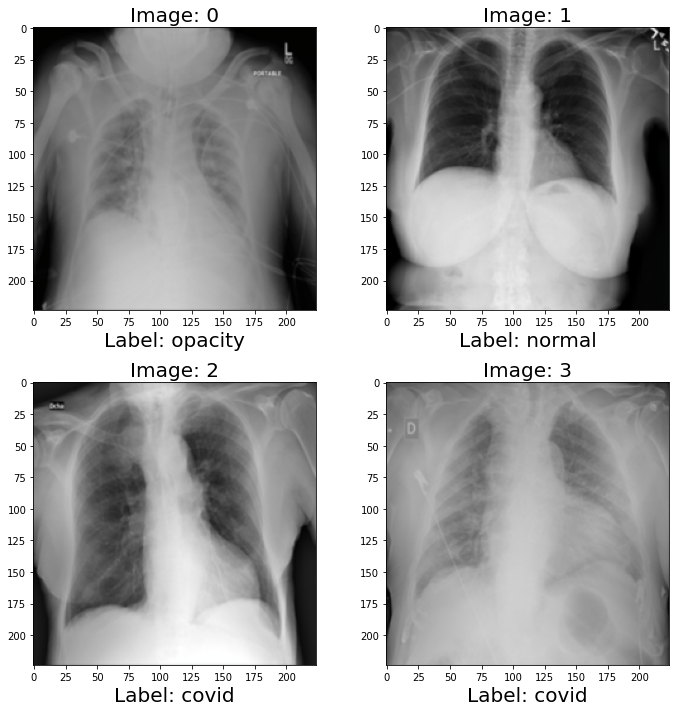

In [76]:
images, labels = next(iter(test_loader))
plot_images(images, labels, labels)

In [77]:
def plot_predictions(images, labels, preds):

    # Set title / label font size
    text_size = 20
    
    # Set classes and figure size
    classes = train_dataset.classes
    plt.figure(figsize=(10,10))
    
    # Get predictions for each image
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    # Plot first 4 images in data loader
    for i, img in enumerate(images):
        plt.subplot(2, 2, i+1)
        
        # Format and normalize images
        img = img.numpy().transpose((1, 2, 0))
        mean_norm = [r_mean, g_mean, b_mean]
        mean  = np.array(mean_norm)
        std_norm = [r_std, g_std, b_std]
        std = np.array(std_norm)
        img_norm = (img*std) + mean
        img_norm = np.clip(img_norm, 0., 1.)
        
        # Plot normalized image with labels and predictions
        plt.imshow(img_norm)
        color_i = 'green'
        if preds[i] != labels[i]:
            color_i = 'red'
        x_label = classes[int(labels[i].numpy())]
        x_label = 'Label: ' + x_label
        plt.xlabel(x_label, size=text_size)
        y_label = classes[int(preds[i].numpy())]
        y_label = 'Prediction: ' + y_label
        plt.ylabel(y_label, color=color_i, size=text_size)
        title = 'Image: ' + str(i)
        plt.title(title, size=text_size)
        if i == 3:
            break
            
    # Show all images     
    plt.tight_layout()
    plt.show()

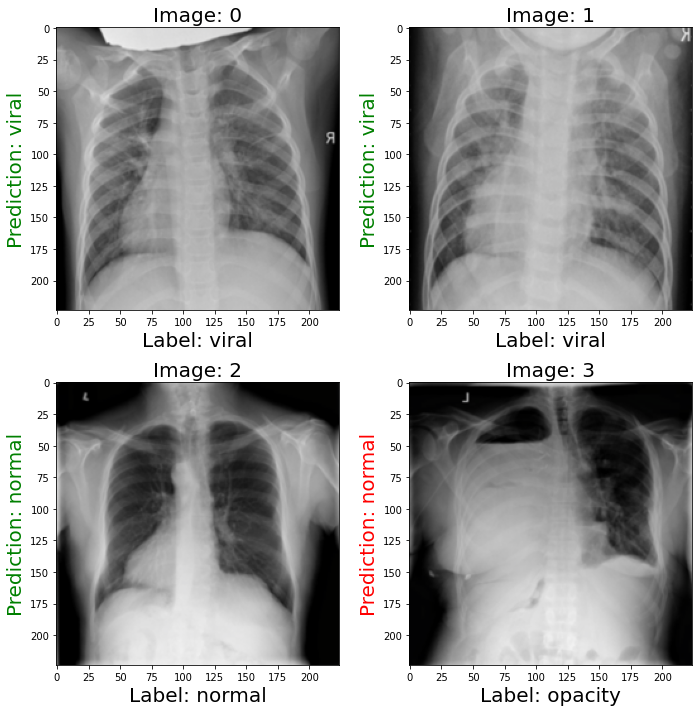

In [78]:
images, labels = next(iter(test_loader))
plot_predictions(images, labels, preds)